<a href="https://colab.research.google.com/github/xynico/Program-for-NMA2021-CN/blob/main/bootstrap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# load the data

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import os, requests

fname = "stringer_spontaneous.npy"
url = "https://osf.io/dpqaj/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

In [4]:
dat = np.load('stringer_spontaneous.npy', allow_pickle=True).item()
print(dat.keys())

dict_keys(['sresp', 'run', 'beh_svd_time', 'beh_svd_mask', 'stat', 'pupilArea', 'pupilCOM', 'xyz'])


# PCA
done by Ruichang

In [6]:
from sklearn.decomposition import PCA

neuron_data = dat['sresp'].T  # 7018*11983, type is np.ndarray

# Figure Out Which K to Choose
X = neuron_data - neuron_data.mean(axis=0)
cov_matrix = (X.T@X) / X.shape[0]
evals, evectors = np.linalg.eigh(cov_matrix)

index = np.flip(np.argsort(evals))
explained_sum = np.cumsum(evals[index])
explained_sum_ratio = explained_sum / explained_sum.max()

# select the first K whose corresponding variance explained >= variance_explained_threshold
variance_explained_threshold = 0.9
k_explain = np.argwhere(explained_sum_ratio>=variance_explained_threshold)
k_chosen = k_explain[0][0]

pca = PCA(n_components = k_chosen)
neuron_data_reduced = pca.fit_transform(neuron_data)

# Bootstrap

In [13]:
# load the PCA data
X_r = neuron_data_reduced
y = dat['run']

In [21]:
# load the function
def resample_with_replacement(x, y):
  sample_idx = np.random.choice(len(y), size = len(y), replace = True ) # len(y)=7018

  x_ = x[sample_idx]
  y_ = y[sample_idx]

  return x_, y_

from sklearn import linear_model
from sklearn.metrics import mean_squared_error

## Calculate the Lasso_MSE by bootstrap
I don't think it's necessary, but it can calculate some MSE for us to see




In [36]:
def bootstrap_MSE_Lasso(x, y, n):

  MSE = []
  
  # Loop over number of estimates
  for i in range(n):

    # Resample x and y
    x_, y_ = resample_with_replacement(x, y)

    # Compute MSE (done by Ruichang)
    lasso = linear_model.Lasso(alpha=0.1)  # select LASSO to further reduce features
    lasso.fit(x_, y_)
    y_pred = lasso.predict(x_)

    MSE.append(mean_squared_error(y_pred, y_))

  return MSE

No handles with labels found to put in legend.


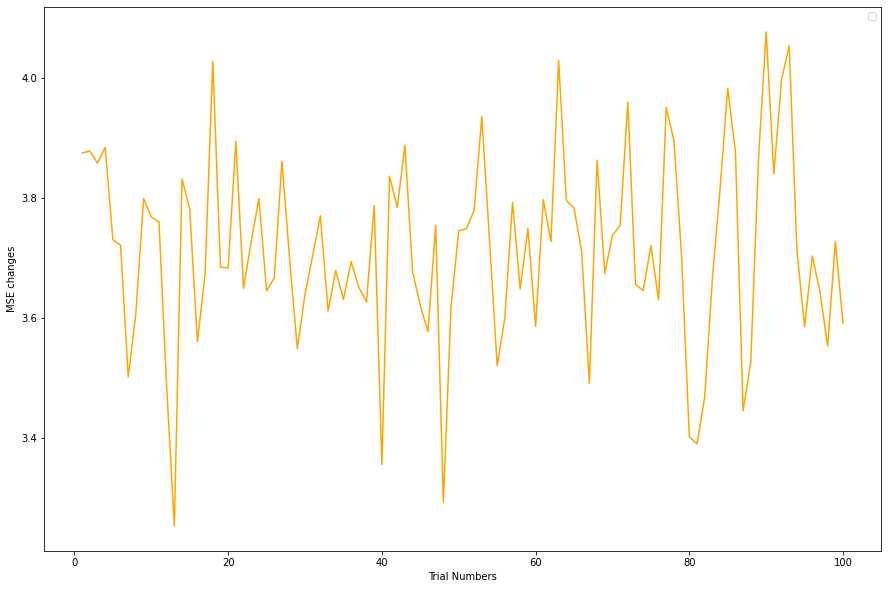

In [62]:
np.random.seed(2021)

N = 100  # bootstrap times
MSE_Lasso = bootstrap_MSE_Lasso(X_r, y, n=N)
plt.figure(figsize=(15,10))
plt.plot(range(1, N+1), MSE_Lasso, color='orange')

plt.legend()
plt.xlabel('Trial Numbers')
plt.ylabel('MSE changes')
plt.show()

In [98]:
def bootstrap_y_pre(x, y, n, trail):

  y_pres = []
  for i in range(n):

    x_, y_ = resample_with_replacement(x, y)

    lasso = linear_model.Lasso(alpha=0.1)  # select LASSO to further reduce features
    lasso.fit(x_, y_)
    y_pres.append(lasso.predict(x_)[trail])

  return y_pres

In [104]:
n = 100 #bootstrap
trial = 2 #one of the 7018 trials
y_pres = bootstrap_y_pre(X_r, y, n, trial)
print(f"mean = {np.mean(y_pres):.2f}, std = {np.std(y_pres):.2f}")

mean = 3.29, std = 8.07


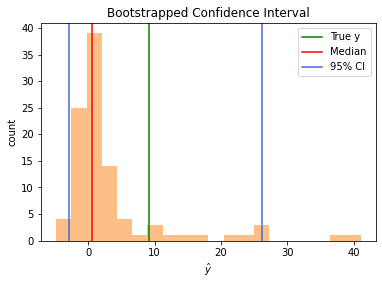

In [110]:
fig, ax = plt.subplots()
ax.hist(y_pres, bins=20, facecolor='C1', alpha=0.5)

ax.axvline(y[trial], c='g', label=r'True y')
ax.axvline(np.percentile(y_pres, 50), color='r', label='Median')
ax.axvline(np.percentile(y_pres, 2.5), color='royalblue', label='95% CI')
ax.axvline(np.percentile(y_pres, 97.5), color='royalblue')

ax.legend()
ax.set(
    title='Bootstrapped Confidence Interval',
    xlabel=r'$\hat{y}$',
    ylabel='count',

);

here I just check for one trial, I don't know how to check all the ys(7018) \\

I think it will take so long time.

## Use bootsrap and compare y_pre & y
with different X_ & y_ \\

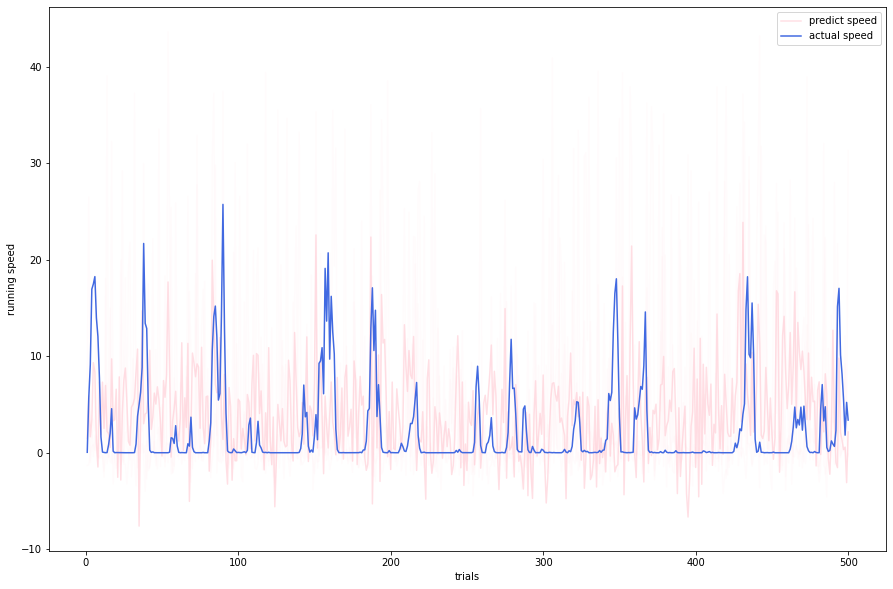

In [78]:
N = 100  # bootstrap times
n = 500 # plot the first n trials

plt.figure(figsize=(15,10))
for i in range(N):
  X_, y_ = resample_with_replacement(X_r, y)
  lasso = linear_model.Lasso(alpha=0.1)  # select LASSO to further reduce features
  lasso.fit(X_, y_)
  y_pred = lasso.predict(X_)

  plt.plot(range(1,len(y_pred[:n])+1), y_pred[:n], c = 'pink', alpha = 0.05)

lasso = linear_model.Lasso(alpha=0.1)  # select LASSO to further reduce features
lasso.fit(X_r, y_)
y_pred = lasso.predict(X_r)
plt.plot(range(1,len(y_pred[:n])+1), y_pred[:n], c = 'pink', alpha = 0.5, label='predict speed')

plt.plot(range(1,len(y[:n])+1), y[:n], c = 'royalblue', label='actual speed')
plt.legend()
plt.xlabel('trials')
plt.ylabel('running speed')
plt.show()